In [38]:
import csv
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocessing import Pool
from tqdm import tqdm
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



### Загружаю уже запарсенный файл

In [19]:
df = pd.read_csv('/Users/arturarakelan/Downloads/twitter_data.csv')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,26,27,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1444206936782741504,1444206936782741504,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,I think #Bitcoin is about to go on a run! #100k,en,"['bitcoin', '100k']",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1,1444206935130132482,1444206935130132482,1633160740000.0,2021-10-02 10:45:40,300.0,NaN,Looking for some crazy NFT shit? 🤪 #NFT #NFTs...,en,"['nft', 'nfts', 'nftfamily', 'nftcollectibles'...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,2,1444206933469274116,1444206933469274116,1633160739000.0,2021-10-02 10:45:39,300.0,NaN,FinanceMagnates: Bitcoin Transaction Volume In...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,3,1444206925898391552,1437427827767271426,1633160737000.0,2021-10-02 10:45:37,300.0,NaN,@babyswap_bsc @BinanceChain @binance @mini_kis...,en,"['minikishu', 'bsc', 'binance', 'bscgems', 'bs...",...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'babyswap_bsc', 'name': 'Baby...",NaN,NaN,NaN,NaN
4,4,1444206921607626759,1444206921607626759,1633160736000.0,2021-10-02 10:45:36,300.0,NaN,This is a great and powerful project which can...,en,"['airdrop', 'pancakeswap', 'btc', 'cryptocurre...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [20]:
# специальный токенизатор для твитов
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()

### Для проверки работоспособности и более быстрого расчета проверяется на выборке размером 10 000

In [21]:
data_try = df[:10000]

In [22]:
%%time

data_try['tokenized_word'] = 0

for i in range(len(data_try['tokenized_word'])):
    data_try['tokenized_word'][i] = TweetTokenizer(data_try['tweet'][i])

#df['tokenized_word'] = df['tweet'].apply(lambda x: TweetTokenizer(x.lower()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1031: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

CPU times: user 5.47 s, sys: 85.1 ms, total: 5.55 s
Wall time: 5.66 s


In [23]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [29]:
%%time
data_try['new_tweets'] = None


for i in range(len(data_try)):
    data_try['new_tweets'][i] = words_only(data_try['tweet'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


CPU times: user 5.11 s, sys: 145 ms, total: 5.26 s
Wall time: 5.19 s


In [30]:

m = MorphAnalyzer()

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    if type(text) != float and text is not None:
        return [lemmatize_word(str(text[i])) for i in range(len(text))]

mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(tokens):
    #tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [31]:
from multiprocessing import Pool
from tqdm import tqdm

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data_try['new_tweets']), total=len(df)))
    
data_try['lemmas'] = lemmas
data_try.sample(5)

  2%|▏         | 10000/542767 [00:01<01:44, 5120.76it/s]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokenized_word,new_tweets,lemmas
9933,9933,1444131162583035906,1444131162583035906,1633142674000.0,2021-10-02 05:44:34,300.0,NaN,I wanna see #Bitcoin have another 5-10% pump t...,en,['bitcoin'],...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[i, wanna, see, bitcoin, have, another, pump, ...",wanna bitcoin another pump tomorrow followed r...
3382,3382,1444185384284528640,1444185384284528640,1633155601000.0,2021-10-02 09:20:01,300.0,NaN,$47737.77 | €41174.88 | ¥400795.82 | £35239.56...,und,"['bitcoinprice', 'cryptocurrency', 'bitcoin']",...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[bitcoinprice, cryptocurrency, bitcoin]",bitcoinprice cryptocurrency bitcoin
4427,4427,1444178555026423808,1444178555026423808,1633153973000.0,2021-10-02 08:52:53,300.0,NaN,OMG eyes a new all-time high after unveiling i...,en,['bitcoin'],...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[omg, eyes, a, new, all, time, high, after, un...",eyes time high unveiling boba network layer so...
3766,3766,1444182869262340096,1444182869262340096,1633155002000.0,2021-10-02 09:10:02,300.0,NaN,"I must call someone today, because that green ...",en,"['cripto', 'btc', 'bitcoin', 'meme', 'buythedi...",...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[i, must, call, someone, today, because, that,...",must call someone today green flag went roof l...
6676,6676,1444158382869565440,1444158382869565440,1633149164000.0,2021-10-02 07:32:44,300.0,NaN,Earn your share of up to $1 million Bitcoin. ...,en,"['bitcoin', 'freebitcoin', 'cryptocurrency']",...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[earn, your, share, of, up, to, million, bitco...",earn share million bitcoin participate make su...


In [33]:
vec = CountVectorizer(ngram_range=(2, 2)) # строим BoW для слов
bow = vec.fit_transform(data_try['lemmas']) 

In [36]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data_try['lemmas']) 

In [39]:
X = tfidf.todense()
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)

X_pca now has just 2 columns:
[[-0.04335207  0.11225356]
 [-0.01179268 -0.05947249]
 [-0.02372758 -0.00492411]
 ...
 [-0.02893864 -0.0149498 ]
 [-0.01925679 -0.03705334]
 [-0.02094423  0.00807043]]


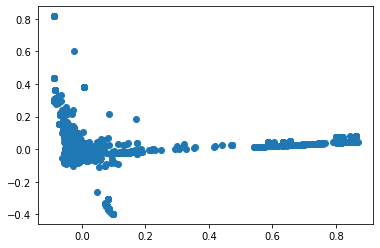

In [41]:
import matplotlib.pyplot as plt


plt.scatter(x = X_pca[:,0], y = X_pca[:,1])

In [44]:
from sklearn.manifold import TSNE

X = tfidf.todense()
X_TSNE = TSNE(n_components=2).fit_transform(X)

print("X_TSNE now has just 2 columns:")
print(X_TSNE)

X_TSNE now has just 2 columns:
[[  6.091423   36.350246 ]
 [ 28.645956   13.251205 ]
 [-64.25137    10.147509 ]
 ...
 [-26.937971   -9.597869 ]
 [ 77.33351    -6.9887905]
 [-32.997784  -50.26268  ]]


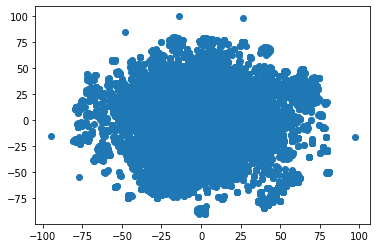

In [45]:
plt.scatter(x = X_TSNE[:,0], y = X_TSNE[:,1])

## Далее идет аналогичный код только для большего размера выборки. Но  в какой-то момент компьютер перестал считать.

In [21]:
%%time

df['tokenized_word'] = 0

for i in range(len(df['tokenized_word'])):
    df['tokenized_word'][i] = TweetTokenizer(df['tweet'][i])

#df['tokenized_word'] = df['tweet'].apply(lambda x: TweetTokenizer(x.lower()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


CPU times: user 27min 50s, sys: 14.1 s, total: 28min 4s
Wall time: 27min 56s


In [60]:
df['new_tweets'] = None
for i in range(len(df['new_tweets'])):
    df['new_tweets'][i] = df['tweet'].findall('[-+][0-9.]+|\S')

AttributeError: 'Series' object has no attribute 'findall'

In [61]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [66]:
%%time

for i in range(len(df)):
    df['new_tweets'][i] = words_only(df['tweet'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CPU times: user 30min 24s, sys: 16.5 s, total: 30min 40s
Wall time: 30min 34s


In [28]:
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

In [51]:
m = MorphAnalyzer()

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    if type(text) != float and text is not None:
        return [lemmatize_word(str(text[i])) for i in range(len(text))]

mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(tokens):
    #tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [67]:
from multiprocessing import Pool
from tqdm import tqdm

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['new_tweets']), total=len(df)))
    
df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 542767/542767 [00:57<00:00, 9442.42it/s] 


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokenized_word,new_tweets,lemmas
35734,35732,1443995004351963136,1443995004351963136,1633110211000.0,2021-10-01 20:43:31,300.0,NaN,Canada Gets Its First Multi-Crypto ETF Pegged ...,en,"['cryptocurrencies', 'ethereum', 'bitcoin']",...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[canada, gets, its, first, multi, crypto, etf,...",canada gets first multi crypto pegged bitcoin ...
325784,212023,1443094822227636226,1443094822227636226,1632895591000.0,2021-09-29 09:06:31,300.0,NaN,Roman found #bitcoin in a User vault at this l...,en,"['bitcoin', 'coinhuntworld', 'cryptocurrency']",...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[roman, found, bitcoin, in, a, user, vault, at...",roman found bitcoin user vault location join p...
212786,119722,1443605684214505475,1443605684214505475,1633017390000.0,2021-09-30 18:56:30,300.0,NaN,The main purpse of Bitcoin is to protect the p...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[the, main, purpse, of, bitcoin, is, to, prote...",main purpse bitcoin protect property individua...
117927,94364,1443730153759289346,1443729760920776705,1633047066000.0,2021-10-01 03:11:06,300.0,NaN,@INDCAmbassador @BotOfDogecoin @elonmusk @BotO...,und,"['dogecoin', 'bitcoin', 'news', 'dogecointothe...",...,NaN,NaN,"[{'screen_name': 'INDCAmbassador', 'name': 'IN...",NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[indcambassador, botofdogecoin, elonmusk, boto...",indcambassador botofdogecoin elonmusk botofdog...
225639,132367,1443550658511134727,1443550658511134727,1633004271000.0,2021-09-30 15:17:51,300.0,NaN,Tough to bet against the authoritarian system ...,en,[],...,NaN,NaN,[],NaN,NaN,NaN,NaN,<nltk.tokenize.casual.TweetTokenizer object at...,"[tough, to, bet, against, the, authoritarian, ...",tough authoritarian system chicoms involves cr...


In [68]:
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams

In [69]:
vec = CountVectorizer(ngram_range=(2, 2)) # строим BoW для слов
bow = vec.fit_transform(df['lemmas']) 

In [90]:
df['new_tweets']

0         [i, think, bitcoin, is, about, to, go, on, a, ...
1         [looking, for, some, crazy, nft, shit, nft, nf...
2         [financemagnates, bitcoin, transaction, volume...
3         [babyswap_bsc, binancechain, binance, mini_kis...
4         [this, is, a, great, and, powerful, project, w...
                                ...                        
542762    [https, t, co, tufwxwz, d, cryptocurrency, cry...
542763    [a, hamster, trading, cryptos, since, june, ha...
542764                                 [bitcoin_defi, good]
542765    [nf, mation, good, project, anonmmm, zay_myel,...
542766                                 [smell, of, bitcoin]
Name: new_tweets, Length: 542767, dtype: object

In [91]:
df['lemmas']

0                                             think bitcoin
1         looking crazy shit nfts nftfamily nftcollectib...
2         financemagnates bitcoin transaction volume inc...
3         babyswap_bsc binancechain binance mini_kishu m...
4         great powerful project change things make brig...
                                ...                        
542762    https tufwxwz cryptocurrency crypto cryptonews...
542763    hamster trading cryptos since june outperforme...
542764                                    bitcoin_defi good
542765    mation good project anonmmm zay_myel aungkya m...
542766                                        smell bitcoin
Name: lemmas, Length: 542767, dtype: object

In [89]:
vec.vocabulary_

{'think bitcoin': 1263534,
 'looking crazy': 810324,
 'crazy shit': 275561,
 'shit nfts': 1159407,
 'nfts nftfamily': 918213,
 'nftfamily nftcollectibles': 917165,
 'nftcollectibles nftcollection': 916506,
 'nftcollection nftopensea': 916569,
 'nftopensea nftcommunity': 917578,
 'nftcommunity bayc': 916852,
 'bayc pudgypenguins': 95068,
 'pudgypenguins cryptopunks': 1046752,
 'cryptopunks satoshibles': 295200,
 'satoshibles whatthefoxes': 1128476,
 'whatthefoxes ooga': 1370254,
 'ooga coolcatsnft': 948226,
 'coolcatsnft apenft': 265453,
 'apenft solana': 56106,
 'solana bitcoin': 1181682,
 'bitcoin ethereum': 127630,
 'ethereum doge': 413855,
 'doge shibainu': 354858,
 'shibainu cardano': 1157728,
 'cardano polkadot': 198837,
 'polkadot binance': 1006337,
 'binance https': 115190,
 'https jcvetbcaix': 609603,
 'financemagnates bitcoin': 454735,
 'bitcoin transaction': 142896,
 'transaction volume': 1293323,
 'volume increases': 1349348,
 'increases sharply': 700851,
 'sharply https': 1

In [71]:
list(vec.vocabulary_.items())[:10]

[('think bitcoin', 1263534),
 ('looking crazy', 810324),
 ('crazy shit', 275561),
 ('shit nfts', 1159407),
 ('nfts nftfamily', 918213),
 ('nftfamily nftcollectibles', 917165),
 ('nftcollectibles nftcollection', 916506),
 ('nftcollection nftopensea', 916569),
 ('nftopensea nftcommunity', 917578),
 ('nftcommunity bayc', 916852)]

In [102]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['lemmas']) 

In [108]:
print(tfidf)

  (0, 27959)	0.23954912833377864
  (0, 263550)	0.9708842439315446
  (1, 134522)	0.29173852302075715
  (1, 119106)	0.05345475313445749
  (1, 27269)	0.10462697922911009
  (1, 209432)	0.14985868177009468
  (1, 39508)	0.08067472301160994
  (1, 243861)	0.18774526449457907
  (1, 69126)	0.11307692376562517
  (1, 84367)	0.07855252282172373
  (1, 248781)	0.12894283544996735
  (1, 12963)	0.24552977919089358
  (1, 50705)	0.2719537871910582
  (1, 196562)	0.28298363794659265
  (1, 292113)	0.28298363794659265
  (1, 238774)	0.21436245331735349
  (1, 54899)	0.19685268316902435
  (1, 214758)	0.26468861022919743
  (1, 22373)	0.2064224650802873
  (1, 184716)	0.1487965560136525
  (1, 184861)	0.24683879835445124
  (1, 184706)	0.18465540197611086
  (1, 184705)	0.1816211699456308
  (1, 184756)	0.2592621779836594
  (1, 184898)	0.12165225541094339
  :	:
  (542762, 119106)	0.08329186465258805
  (542762, 84367)	0.12239858413580063
  (542762, 27959)	0.04632217646853729
  (542763, 152785)	0.5715048674136939
  (542

In [ ]:
X = tfidf.todense()
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)

In [79]:
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_cluster_ids

In [94]:
DF = {}
for i in range(len(df['lemmas'])):
    tokens = df['lemmas'][i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [101]:
tf_idf = {}
N = len(df['lemmas'])
for i in range(N):
    tokens = df['lemmas'][i]
    counter = len(tokens)
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log(N/(df+1))
        tf_idf[doc, token] = tf*idf

TypeError: 'int' object is not subscriptable

In [77]:
# define transform
pca = PCA()
# prepare transform on dataset
pca.fit(df['lemmas'])
# apply transform to dataset
transformed = pca.transform(df['lemmas'])

ValueError: could not convert string to float: 'think bitcoin'

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(vec)
#d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)
d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, d2v_pca.n_components_+1)
ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

TypeError: float() argument must be a string or a number, not 'CountVectorizer'